In [1]:
# import sys
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)
# SRC_PATH = '/content/gdrive/MyDrive/MP FEB/Colab'
# sys.path.append(SRC_PATH)

# !pip install wandb -qqq
# import wandb
# wandb.login()

# wandb.init(
#     # Set the project where this run will be logged
#     project="baseline_poc", 
#     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#     #name="experiment 1"
#     # Track hyperparameters and run metadata
#     #config={
#       #"learning_rate": 0.02,
#       #"architecture": "CNN",
#       #"dataset": "CIFAR-100",
#       #"epochs": 10,}
#     )

In [2]:
%load_ext autoreload
%autoreload 2

import dask.dataframe as dd
import os
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

### 1.1 Loading raw data

In [3]:
data_folder = str(os.getcwd()) + "\data"

blumenstock_types = {'LOAN_SEQUENCE_NUMBER': str, 'INT_RATE': float, 'ORIG_UPB': float, 'FICO_SCORE': float,
                    'DTI_R': float, 'LTV_R': float, 'FIRST_PAYMENT_DATE': str, 'BAL_REPAID': float, 'T_ACT_12M': float, 'T_DEL_30D': float, 
                    'T_DEL_60D': float, 'LABEL': float, 'REMAINING_MONTHS_TO_LEGAL_MATURITY': float, "TIME_TO_EVENT": float, 'TOTAL_OBSERVED_LENGTH': float}


df_blumenstock = dd.read_parquet(data_folder + "./blumenstock_labeled_sample_orig_*.parquet.gzip")
df_blumenstock = df_blumenstock.astype(blumenstock_types)

In [4]:
df_blumenstock.head(10)

,LOAN_SEQUENCE_NUMBER,INT_RATE,ORIG_UPB,FICO_SCORE,DTI_R,LTV_R,FIRST_PAYMENT_DATE,REMAINING_MONTHS_TO_LEGAL_MATURITY,TOTAL_OBSERVED_LENGTH,TIME_TO_EVENT,LABEL,BAL_REPAID,T_ACT_12M,T_DEL_30D,T_DEL_60D
0,F10Q10000014,4.375,216000.0,784.0,38.0,80.0,201005,156.0,25.0,25.0,0.0,0.901226,12.0,0.0,0.0
1,F10Q10000069,4.500,200000.0,795.0,35.0,67.0,201003,156.0,25.0,25.0,0.0,0.836209,12.0,0.0,0.0
2,F10Q10000089,4.500,146000.0,784.0,47.0,55.0,201003,120.0,61.0,61.0,0.0,0.724131,12.0,0.0,0.0
3,F10Q10000115,4.500,68000.0,794.0,30.0,55.0,201003,115.0,66.0,66.0,0.0,0.711440,12.0,0.0,0.0
4,F10Q10000302,4.375,250000.0,726.0,55.0,60.0,201003,143.0,38.0,38.0,0.0,0.844081,12.0,0.0,0.0
5,F10Q10000332,4.750,70000.0,760.0,24.0,42.0,201003,62.0,119.0,119.0,0.0,0.073537,12.0,0.0,0.0
6,F10Q10000658,4.000,361000.0,755.0,44.0,57.0,201003,145.0,36.0,36.0,0.0,0.847537,12.0,0.0,0.0
7,F10Q10000681,4.375,124000.0,719.0,45.0,80.0,201003,67.0,114.0,114.0,0.0,0.344512,12.0,0.0,0.0
8,F10Q10000913,4.375,165000.0,721.0,35.0,59.0,201003,98.0,83.0,83.0,0.0,0.596179,12.0,0.0,0.0
9,F10Q10000944,4.375,142000.0,792.0,10.0,32.0,201003,113.0,68.0,68.0,0.0,0.677846,12.0,0.0,0.0


### 1.2 Normalising raw data

In [5]:
covariates_to_normalise = ['INT_RATE', 'ORIG_UPB', 'FICO_SCORE', 'DTI_R', 'LTV_R', 'REMAINING_MONTHS_TO_LEGAL_MATURITY',
                           'BAL_REPAID', 'T_ACT_12M', 'T_DEL_30D', 'T_DEL_60D']

df_blumenstoch_mean = df_blumenstock[covariates_to_normalise].mean().compute()
df_blumenstoch_std = df_blumenstock[covariates_to_normalise].std().compute()

df_blumenstock[covariates_to_normalise] = (df_blumenstock[covariates_to_normalise] - df_blumenstoch_mean) / df_blumenstoch_std


In [6]:
df_blumenstock.head(10)

,LOAN_SEQUENCE_NUMBER,INT_RATE,ORIG_UPB,FICO_SCORE,DTI_R,LTV_R,FIRST_PAYMENT_DATE,REMAINING_MONTHS_TO_LEGAL_MATURITY,TOTAL_OBSERVED_LENGTH,TIME_TO_EVENT,LABEL,BAL_REPAID,T_ACT_12M,T_DEL_30D,T_DEL_60D
0,F10Q10000014,0.657758,0.479923,0.261876,-0.661558,0.947833,201005,1.082756,25.0,25.0,0.0,1.142886,0.119319,-0.123631,-0.067393
1,F10Q10000069,0.930986,0.318299,0.410433,-0.668209,0.312000,201003,1.082756,25.0,25.0,0.0,0.926180,0.119319,-0.123631,-0.067393
2,F10Q10000089,0.930986,-0.227181,0.261876,-0.641604,-0.274923,201003,0.233697,61.0,61.0,0.0,0.552615,0.119319,-0.123631,-0.067393
3,F10Q10000115,0.930986,-1.015098,0.396928,-0.679295,-0.274923,201003,0.115772,66.0,66.0,0.0,0.510314,0.119319,-0.123631,-0.067393
4,F10Q10000302,0.657758,0.823374,-0.521425,-0.623868,-0.030371,201003,0.776151,38.0,38.0,0.0,0.952417,0.119319,-0.123631,-0.067393
5,F10Q10000332,1.477441,-0.994895,-0.062248,-0.692597,-0.910756,201003,-1.134232,119.0,119.0,0.0,-1.615867,0.119319,-0.123631,-0.067393
6,F10Q10000658,-0.161925,1.944640,-0.129774,-0.648256,-0.177102,201003,0.823321,36.0,36.0,0.0,0.963936,0.119319,-0.123631,-0.067393
7,F10Q10000681,0.657758,-0.449414,-0.615961,-0.646039,0.947833,201003,-1.016307,114.0,114.0,0.0,-0.712686,0.119319,-0.123631,-0.067393
8,F10Q10000913,0.657758,-0.035253,-0.588951,-0.668209,-0.079282,201003,-0.285173,83.0,83.0,0.0,0.126142,0.119319,-0.123631,-0.067393
9,F10Q10000944,0.657758,-0.267587,0.369917,-0.723636,-1.399858,201003,0.068602,68.0,68.0,0.0,0.398345,0.119319,-0.123631,-0.067393


### 1.3 Creating dataloaders

In [7]:
from torch.utils.data import DataLoader
from FREDDIEMAC_baseline_data import FREDDIEMAC_basline_dataset, FREDDIEMAC_dataloader

BATCH_SIZE = 2**8

frac_cases=0.25
test_set = False
augment = False
data_augment_factor = 3
random_state = 42

allowed_covariates = ['INT_RATE', 'ORIG_UPB', 'FICO_SCORE', 'DTI_R','LTV_R', 'BAL_REPAID', 
                     'T_ACT_12M', 'T_DEL_30D', 'T_DEL_60D', 'REMAINING_MONTHS_TO_LEGAL_MATURITY']

TIME_TO_EVENT_covariate = 'TIME_TO_EVENT'
LABEL_covariate = 'LABEL'


FREDDIEMAC_raw_dataset = FREDDIEMAC_basline_dataset(df_blumenstock, 
                                                    allowed_covariates,
                                                    TIME_TO_EVENT_covariate,
                                                    LABEL_covariate,
                                                    frac_cases,
                                                    random_state,
                                                    test_set,
                                                    augment,
                                                    data_augment_factor)

print("This dataset will contain %d samples" % len(FREDDIEMAC_raw_dataset))

data_loader = FREDDIEMAC_dataloader(dataset=FREDDIEMAC_raw_dataset,
                                    batch_size=BATCH_SIZE)

print("This dataloader will deliver %d batches" % data_loader.get_max_iterations())

batch_data, batch_data_length, batch_event, batch_tte = next(data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 6154 samples
This dataloader will deliver 24 batches
torch.Size([256, 1, 10])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])


### Data Exploration

In [8]:
batch_data, batch_data_length, batch_event, batch_tte = next(iter(data_loader))

for i in range(min(BATCH_SIZE, 16)):
    print("batch event= %d --- batch_data_length= %d --- batch_tte= %d" % (batch_event[i], batch_data_length[i], batch_tte[i]))

batch event= 0 --- batch_data_length= 114 --- batch_tte= 114
batch event= 0 --- batch_data_length= 20 --- batch_tte= 20
batch event= 0 --- batch_data_length= 123 --- batch_tte= 123
batch event= 0 --- batch_data_length= 74 --- batch_tte= 74
batch event= 0 --- batch_data_length= 80 --- batch_tte= 80
batch event= 3 --- batch_data_length= 143 --- batch_tte= 143
batch event= 0 --- batch_data_length= 16 --- batch_tte= 16
batch event= 0 --- batch_data_length= 36 --- batch_tte= 36
batch event= 0 --- batch_data_length= 27 --- batch_tte= 27
batch event= 3 --- batch_data_length= 143 --- batch_tte= 143
batch event= 0 --- batch_data_length= 141 --- batch_tte= 141
batch event= 0 --- batch_data_length= 27 --- batch_tte= 27
batch event= 0 --- batch_data_length= 61 --- batch_tte= 61
batch event= 0 --- batch_data_length= 17 --- batch_tte= 17
batch event= 0 --- batch_data_length= 31 --- batch_tte= 31
batch event= 0 --- batch_data_length= 36 --- batch_tte= 36


### Test Sample (that is possibly in training set right now :p )

In [9]:
frac_cases=0.00004

FREDDIEMAC_raw_dataset = FREDDIEMAC_basline_dataset(df_blumenstock, 
                                                    allowed_covariates,
                                                    TIME_TO_EVENT_covariate,
                                                    LABEL_covariate,
                                                    frac_cases,
                                                    random_state,
                                                    test_set,
                                                    augment,
                                                    data_augment_factor)

test_data_loader = FREDDIEMAC_dataloader(dataset=FREDDIEMAC_raw_dataset, batch_size=1)
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))
print("This dataset will contain %d samples" % len(FREDDIEMAC_raw_dataset))
print("This dataloader will deliver %d batches" % test_data_loader.get_max_iterations())
print("batch event= %d --- batch_data_length= %d --- batch_tte= %d" % (test_batch_event[0], test_batch_data_length[0], test_batch_tte[0]))

This dataset will contain 1 samples
This dataloader will deliver 1 batches
batch event= 0 --- batch_data_length= 26 --- batch_tte= 26


# 2. Hyperparameters

In [10]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam

from deepHit import Encoder, CauseSpecificSubnetwork, DeepHit
from baseline_losses import loss_1_batch, loss_2_batch

NUM_EPOCHS = 10

LEARNING_RATE_ENCODER = 1e-3
LEARNING_RATE_CAUSESS = 1e-3

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 1

RUN_VALIDATION_ROUND = False
VAL_NUM_CASES_RUNTIME = BATCH_SIZE

input_size = FREDDIEMAC_raw_dataset.get_num_covariates()
output_size = FREDDIEMAC_raw_dataset.get_num_covariates()
MAX_LENGTH = FREDDIEMAC_raw_dataset.get_max_length()
NUM_CAUSES = 3
hidden_size_encoder = 512
context_size = 256
hidden_cause_size = 512
SIGMA = 0.1

# 3. Defining The Model

In [11]:
# initialize model
encoder = Encoder(input_size, hidden_size_encoder, context_size).to(DEVICE)
causess = CauseSpecificSubnetwork(context_size, hidden_cause_size, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DHT = DeepHit(encoder, causess, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)

### Testing a sample before training

sample has length 26
the model predicts the event 2 at time 14
probability of prepay event = 0.04
probability of default event = 0.04
probability of full repay event = 0.04


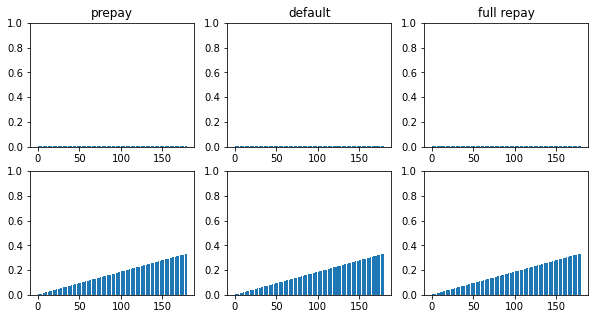

In [12]:
from utils import plot_fht_and_cif_baseline
from baseline_losses import CIF_K

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.unsqueeze(0).to(DEVICE)
test_batch_data_length = test_batch_data_length.unsqueeze(0).to(DEVICE)
test_batch_event = test_batch_event.unsqueeze(0).to(DEVICE)

DHT.eval()

test_first_hitting_time = DHT(test_batch_data, test_batch_data_length)
print("sample has length %d" % test_batch_data_length[0])

test_first_hitting_time_argmax = test_first_hitting_time.argmax().item()
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH
print("the model predicts the event %d at time %d" % (model_event_prediction, model_tte_prediction + 1))

print("probability of prepay event = %.2f" % CIF_K(test_first_hitting_time[0], 0, MAX_LENGTH)[23].item())
print("probability of default event = %.2f" % CIF_K(test_first_hitting_time[0], 1, MAX_LENGTH)[23].item())
print("probability of full repay event = %.2f" % CIF_K(test_first_hitting_time[0], 2, MAX_LENGTH)[23].item())

plot_fht_and_cif_baseline(test_first_hitting_time[0], MAX_LENGTH)

In [13]:
#PATH = "/content/gdrive/MyDrive/MP FEB/Colab/models/baseline_model_v4.pth"

train_data_loader = data_loader

# start training
for epoch in range(NUM_EPOCHS):
  epoch_loss = 0

  for batch_number in range(len(train_data_loader)):
    data = next(train_data_loader)

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event, batch_tte = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    batch_tte = batch_tte.to(DEVICE)
    
    first_hitting_time_batch = DHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_tte, MAX_LENGTH, DEVICE)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_tte, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)

    batch_loss = loss1 + loss2
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    #wandb.log({"train_loss1": loss1.item(), "train_loss2": loss2.item()})
    print({"train_loss1": loss1.item(), "train_loss2": loss2.item()})

    optimizer_encoder.step()
    optimizer_causess.step()

    # if batch_number % 2**8 == 0:
    #   torch.save(DHT.state_dict(), PATH)

#   if RUN_VALIDATION_ROUND:
#     # validating round
#     DHT.eval()

#     with torch.no_grad():
#       val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
#       val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
#       val_batch_data, val_data_length, val_batch_event, val_batch_tte, _ = next(iter(val_data_loader))
#       val_batch_data = val_batch_data.to(DEVICE)
#       val_data_length = val_data_length.to(DEVICE)
#       val_batch_event = val_batch_event.to(DEVICE)
#       val_batch_tte = val_batch_tte.to(DEVICE)

#       val_first_hitting_time_batch = DHT(val_batch_data, val_data_length)

#       val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, MAX_LENGTH, DEVICE)/VAL_NUM_CASES_RUNTIME
#       val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME

#       wandb.log({"val_loss1": val_loss1.item(), "val_loss2": val_loss2.item()})
#       wandb.log({"train_epoch_loss" : epoch_loss.item(), "val_epoch_loss" : val_loss1.item() + val_loss2.item(),"epoch": epoch})

#     DHT.train()
#     # end validating round

  #torch.save(DHT.state_dict(), PATH)

#wandb.finish() 

{'train_loss1': 1449.4342041015625, 'train_loss2': 123.984375}
{'train_loss1': 1442.89111328125, 'train_loss2': 123.984375}
{'train_loss1': 1431.0067138671875, 'train_loss2': 123.984375}
{'train_loss1': 1404.2247314453125, 'train_loss2': 123.984375}
{'train_loss1': 1349.435791015625, 'train_loss2': 123.984375}
{'train_loss1': 1256.455322265625, 'train_loss2': 123.984375}
{'train_loss1': 1179.992919921875, 'train_loss2': 123.984375}
{'train_loss1': 1203.9754638671875, 'train_loss2': 123.984375}
{'train_loss1': 1143.074951171875, 'train_loss2': 123.984375}
{'train_loss1': 1099.81787109375, 'train_loss2': 123.984375}
{'train_loss1': 1090.565673828125, 'train_loss2': 123.984375}
{'train_loss1': 1094.1580810546875, 'train_loss2': 123.984375}


KeyboardInterrupt: 

In [ ]:
from utils import plot_fht_and_cif_baseline
from baseline_losses import CIF_K

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))
test_batch_data = test_batch_data.unsqueeze(0).to(DEVICE)
test_batch_data_length = test_batch_data_length.unsqueeze(0).to(DEVICE)
test_batch_event = test_batch_event.unsqueeze(0).to(DEVICE)

DHT.eval()

test_first_hitting_time = DHT(test_batch_data, test_batch_data_length)
print("sample has length %d" % test_batch_data_length[0])

test_first_hitting_time_argmax = test_first_hitting_time.argmax().item()
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH
print("the model predicts the event %d at time %d" % (model_event_prediction, model_tte_prediction + 1))

print("probability of prepay event = %.2f" % CIF_K(test_first_hitting_time[0], 0, MAX_LENGTH)[23].item())
print("probability of default event = %.2f" % CIF_K(test_first_hitting_time[0], 1, MAX_LENGTH)[23].item())
print("probability of full repay event = %.2f" % CIF_K(test_first_hitting_time[0], 2, MAX_LENGTH)[23].item())

plot_fht_and_cif_baseline(test_first_hitting_time[0], MAX_LENGTH)